# Dimensionality Reduction and Clustering for Exploratory Data Analysis

An important step in data analysis is data exploration and representation. We have already seen some concepts in Exploratory Data Analysis and how to use them in Python. In this tutorial we will see how by combining a technique called [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) together with [Cluster Analysis](https://en.wikipedia.org/wiki/Cluster_analysis) we can **represent in a two dimensional space data defined in a higher dimensional one** while, at the same time, being able to group this data in similar groups or clusters and **find hidden relationships in our data**.  

More concretely, PCA reduces data dimensionality by finding **principal components**. These are the directions of maximum variation in a dataset. By reducing a dataset original features or variables to a reduced set of new ones based on the principal components, we end up with the minimum number of variables that keep the **maximum amount of variation or information about how the data is distributed**. If we end up with just two of these new variables, we will be able to represent each sample in our data in a two dimensional chart (e.g. a scatterplot).   

As an unsupervised data analysis technique, clustering organises data samples by proximity based on its variables. By doing so we will be able to understand how each data point relates to each other and discover groups of similar ones. Once we have each of this groups or clusters, we will be able to define a centroid for them, an ideal data sample that minimises the sum of the distances to each of the data points in a cluster. By analysing these centroids variables we will be able to define each cluster in terms of its characteristics.  

But enough theory for today. Let's put these ideas in practice by using Python and R so we better understand them in order to apply them in the future.  

## Getting and preparing data

The [Gapminder website](http://www.gapminder.org/) presents itself as *a fact-based worldview*. It is a comprehensive resource for data regarding different countries and territories indicators. Its [Data section](http://www.gapminder.org/data/) contains a list of datasets that can be accessed as Google Spreadsheet pages (add `&output=csv` to download as CSV). Each indicator dataset is tagged with a *Data provider*, a *Category*, and a *Subcategory*.  

For this tutorial, we will use a dataset related to prevalence of Infectious Tuberculosis:  


- [TB estimated prevalence (existing cases) per 100K](https://docs.google.com/spreadsheets/d/1X5Jp7Q8pTs3KLJ5JBWKhncVACGsg5v4xu6badNs4C7I/pub?gid=0)  

We invite the reader to repeat the process with the new cases and deaths datasets and share the results.  

This notebook is about exploring the countries distribution. Therefore we will work with datasets where each sample is a country and each variable is a year.    

So first, we need to download Google Spreadsheet data as CSV.

In [4]:
import urllib

#tb_existing_url_csv = 'https://docs.google.com/spreadsheets/d/1X5Jp7Q8pTs3KLJ5JBWKhncVACGsg5v4xu6badNs4C7I/pub?gid=0&output=csv'
local_tb_existing_file = '../data/grouped_airport.csv'
#existing_f = urllib.urlretrieve(tb_existing_url_csv, local_tb_existing_file)

Now that we have it locally, we need to read the CSV file as a data frame.  

In [5]:
import pandas as pd

existing_df = pd.read_csv(local_tb_existing_file, index_col = 0, thousands  = ',')
existing_df.index.names = ['city']
existing_df.columns.names = ['weather']

We have specified `index_col` to be 0 since we want the country names to be the row labels. We also specified the `thousands` separator to be ',' so Pandas automatically parses cells as numbers. We can use `head()` to check the first few lines.  

In [8]:
existing_df = existing_df.fillna(15) #fill N/A with 15 (TODO needs to be the average of city)
existing_df.head()

weather,tempMin-2008-01,tempMax-2008-01,cloudCover-2008-01,visibility-2008-01,pressure-2008-01,windSpeed-2008-01,dewPoint-2008-01,tempMin-2008-02,tempMax-2008-02,cloudCover-2008-02,...,pressure-2008-11,windSpeed-2008-11,dewPoint-2008-11,tempMin-2008-12,tempMax-2008-12,cloudCover-2008-12,visibility-2008-12,pressure-2008-12,windSpeed-2008-12,dewPoint-2008-12
city,,,,,,,,,,,,,,,,,,,,,
Nassau,19.263226,26.030645,15.000000,12.137097,15.000000,4.155161,18.280645,21.070690,28.011379,0.421724,...,1017.784000,4.225000,18.804667,20.414667,26.424333,0.475333,12.186000,1021.956000,4.100333,18.656333
Belize City,18.331935,27.711935,0.522903,11.731613,15.000000,2.881935,20.799032,19.513448,29.764138,0.511379,...,1016.563667,2.654000,19.706000,17.038000,28.108333,0.561667,11.750333,15.000000,2.947667,20.443667
Calgary,-14.024839,-2.179677,0.627419,14.600645,1014.446452,3.116774,-13.874194,-11.639655,0.403448,0.591379,...,1016.357000,2.337667,-4.514667,-15.312000,-5.344333,0.753333,12.783333,1018.465000,3.098000,-14.832000
Edmonton,-19.891935,-7.812903,0.675484,14.311290,1014.531613,2.911935,-16.327742,-18.017586,-5.833448,0.666897,...,1015.507000,3.125667,-4.481000,-21.133000,-9.307333,0.681000,13.902667,1019.470333,2.756667,-18.134000
Vancouver,0.854839,4.999032,0.773548,15.157419,1014.276452,3.390645,-0.054194,2.963448,7.737931,0.748276,...,1017.588000,2.916000,5.880333,-0.575333,3.542333,0.822333,12.849667,1016.315000,2.598333,-1.464667


## Dimensionality reduction with PCA

In this section we want to be able to represent each country in a two dimensional space. In our dataset, each sample is a country defined by 18 different variables, each one corresponding to TB cases counts per 100K (existing, new, deaths) for a given year from 1990 to 2007.  These variables represent not just the total counts or average in the 1990-2007 range but also all the variation in the time series and relationships within countries in a given year. By using PCA we will be able to reduce these 18 variables to just the two of them that best captures that information.  

In order to do so, we will first how to perform PCA and plot the first two PCs in both, Python and R. We will close the section by analysing the resulting plot and each of the two PCs.  

Python's sklearn machine learning library comes with a [PCA implementation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). This implementation uses the `scipy.linalg` implementation of the [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition). It only works for dense arrays (see [numPy dense arrays](http://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html) or [sparse array PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html#sklearn.decomposition.SparsePCA) if you are using sparse arrays) and is not scalable to large dimensional data. For large dimensional data we should consider something such as [Spark's dimensionality reduction features](http://spark.apache.org/docs/latest/mllib-dimensionality-reduction.html). In our case we just have 18 variables, and that is far from being a large number of features for any machine learning library and computer nowadays.    

When using this implementation of PCA we need to specify in advance the number of principal components we want to use. Then we can just call the `fit()` method with our data frame and check the results.  

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(existing_df)

PCA(copy=True, n_components=2, whiten=False)

This gives us an object we can use to transform our data by calling `transform`.

In [10]:
existing_2d = pca.transform(existing_df)

Or we could have just called `fit_transform` to perform both steps in one single call.  

In both cases we will end up with a lower dimension representation of our data frame, as a numPy array. Let's put it in a new dataframe. 

In [11]:
existing_df_2d = pd.DataFrame(existing_2d)
existing_df_2d.index = existing_df.index
existing_df_2d.columns = ['PC1','PC2']
existing_df_2d.head()

,PC1,PC2
city,,
Nassau,-350.370375,-496.553653
Belize City,-312.029578,-591.174650
Calgary,516.410365,-31.201513
Edmonton,514.471203,-31.997459
Vancouver,522.020788,-31.351119


We can also print the explained variance ratio as follows.

In [12]:
print(pca.explained_variance_ratio_) 

[ 0.70462627  0.05073634]


We see that the first PC already explains almost 92% of the variance, while the second one accounts for another 6% for a total of almost 98% between the two of them.

Now we are ready to plot the lower dimensionality version of our dataset. We just need to call plot on the data frame, by passing the kind of plot we want (see [here](http://pandas.pydata.org/pandas-docs/version/0.15.0/visualization.html) for more on plotting data frames) and what columns correspond to each axis. We also add an annotation loop that tags every point with its country name.    

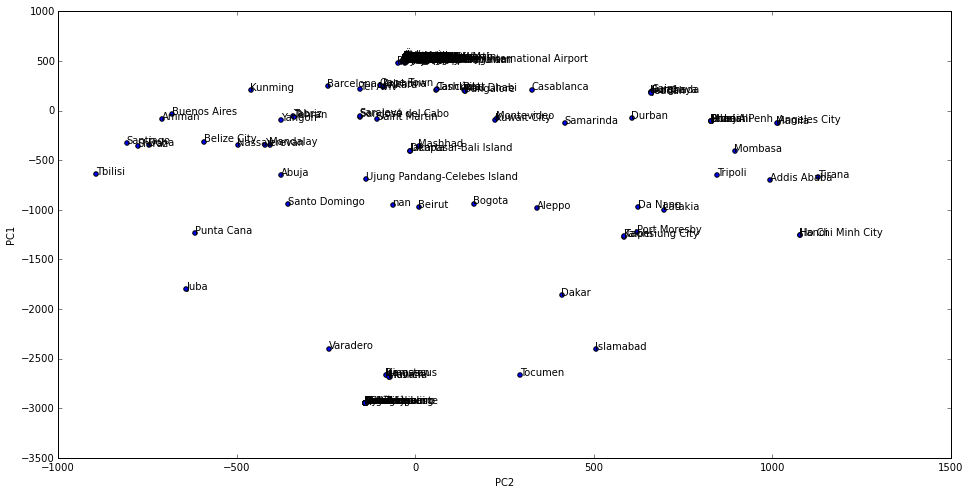

In [13]:
%matplotlib inline

ax = existing_df_2d.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, country in enumerate(existing_df.index):
    ax.annotate(country, (existing_df_2d.iloc[i].PC2, existing_df_2d.iloc[i].PC1))

Let's now create a bubble chart, by setting the point size to a value proportional to the mean value for all the years in that particular country. First we need to add a new column containing the re-scaled mean per country across all the years.       

In [14]:
from sklearn.preprocessing import normalize

existing_df_2d['country_mean'] = pd.Series(existing_df.mean(axis=1), index=existing_df_2d.index)
country_mean_max = existing_df_2d['country_mean'].max()
country_mean_min = existing_df_2d['country_mean'].min()
country_mean_scaled = (existing_df_2d.country_mean-country_mean_min) / country_mean_max
existing_df_2d['country_mean_scaled'] = pd.Series(
    country_mean_scaled, 
    index=existing_df_2d.index)
existing_df_2d.head()

,PC1,PC2,country_mean,country_mean_scaled
city,,,,
Nassau,-350.370375,-496.553653,123.210213,0.725518
Belize City,-312.029578,-591.174650,121.784734,0.716527
Calgary,516.410365,-31.201513,148.632993,0.885882
Edmonton,514.471203,-31.997459,147.914578,0.881351
Vancouver,522.020788,-31.351119,151.630316,0.904789


Now we are ready to plot using this variable size (we will ommit the country names this time since we are not so interested in them).  

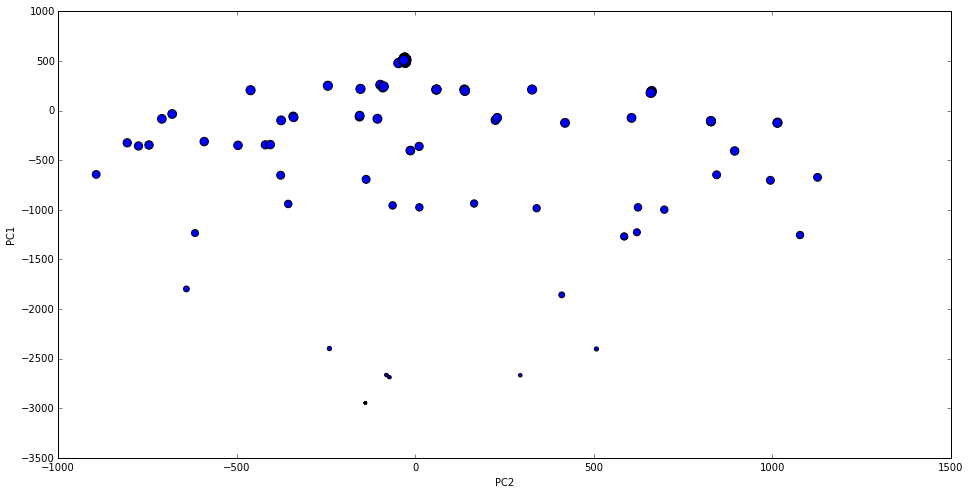

In [15]:
existing_df_2d.plot(kind='scatter', x='PC2', y='PC1', s=existing_df_2d['country_mean_scaled']*100, figsize=(16,8))

Let's do the same with the sum instead of the mean.  

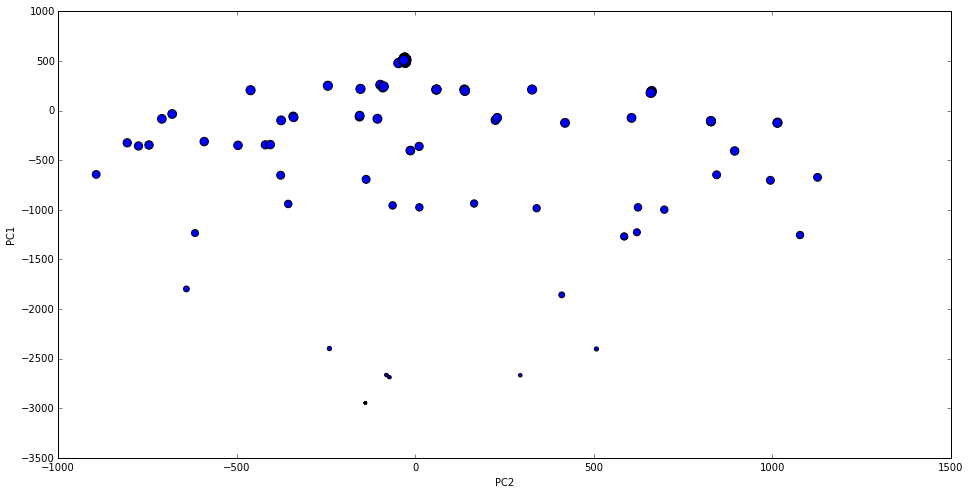

In [16]:
existing_df_2d['country_sum'] = pd.Series(existing_df.sum(axis=1), index=existing_df_2d.index)
country_sum_max = existing_df_2d['country_sum'].max()
country_sum_min = existing_df_2d['country_sum'].min()
country_sum_scaled = (existing_df_2d.country_sum-country_sum_min) / country_sum_max
existing_df_2d['country_sum_scaled'] = pd.Series(
    country_sum_scaled, 
    index=existing_df_2d.index)
existing_df_2d.plot(kind='scatter', x='PC2', y='PC1', s=existing_df_2d['country_sum_scaled']*100, figsize=(16,8))

And finally let's associate the size with the change between 1990 and 2007. Note that in the scaled version, those values close to zero will make reference to those with negative values in the original non-scaled version, since we are scaling to a [0,1] range.  

In [17]:
existing_df_2d['country_change'] = pd.Series(existing_df['2007']-existing_df['1990'], index=existing_df_2d.index)
country_change_max = existing_df_2d['country_change'].max()
country_change_min = existing_df_2d['country_change'].min()
country_change_scaled = (existing_df_2d.country_change - country_change_min) / country_change_max
existing_df_2d['country_change_scaled'] = pd.Series(
    country_change_scaled, 
    index=existing_df_2d.index)
existing_df_2d[['country_change','country_change_scaled']].head()

KeyError: '2007'

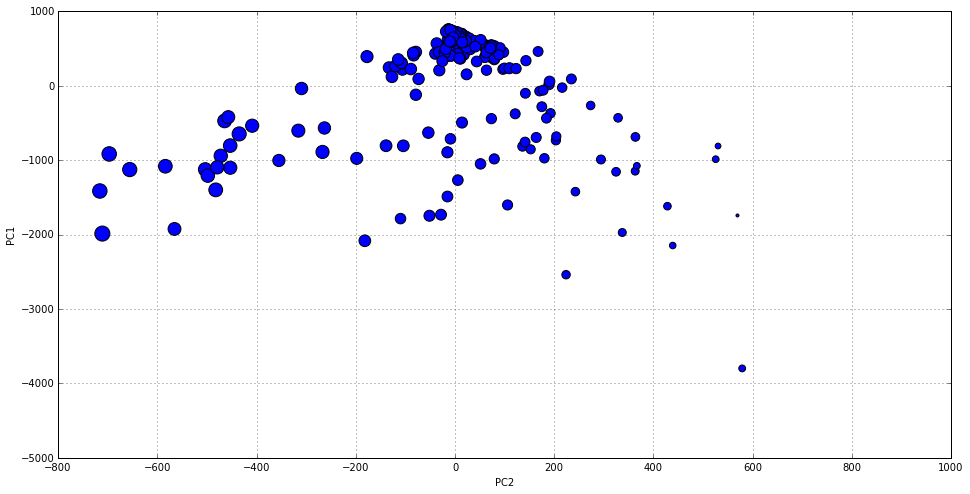

In [33]:
existing_df_2d.plot(kind='scatter', x='PC2', y='PC1', s=existing_df_2d['country_change_scaled']*100, figsize=(16,8))

### PCA Results

From the plots we have done, we can confirm that most variation happens along the y axis, that we have assigned to PC1.  We saw that the first PC already explains almost 92% of the variance, while the second one accounts for another 6% for a total of almost 98% between the two of them. At the very top of our charts we could see an important concentration of countries, mostly developed. While we descend that axis, the number of countries is more sparse, and they belong to less developed regions of the world.   

When sizing points using two absolute magnitudes such as average and total number of cases, we can see that the directions also correspond to a variation in these magnitudes.  

Moreover, when using size to code the difference in the number of cases over time (2007 minus 1990), the size mostly changed along the direction of the second principal component, with more positive values (i.e. increase in the number of cases) having a bigger size. That is, while the first PC captures most of the variation within our dataset and this variation is based on the total cases in the 1990-2007 range, the second PC is largely affected by the change over time. 

In the next section we will try to discover other relationships between countries.  

## Uncovering data structure with k-means clustering 

In this section we will use [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to group countries based on how similar their situation has been year-by-year. That is, we will cluster the data based in the 18 variables that we have. Then we will use the cluster assignment to colour the previous 2D chart, in order to discover hidden relationship within our data and better understand the world situation regarding the tuberculosis disease.  

When using k-means, we need to determine the right number of groups for our case. This can be done more or less accurately by iterating through different values for the number of groups and compare an amount called the within-cluster sum of square distances for each iteration. This is the squared sum of distances to the cluster center for each cluster member. Of course this distance is minimal when the number of clusters gets equal to the number of samples, but we don't want to get there. We normally stop when the improvement in this value starts decreasing at a lower rate.   
 
However, we will use a more intuitive approach based on our understanding of the world situation and the nature of the results that we want to achieve. Sometimes this is the way to go in data analysis, specially when doing exploration tasks. To use the knowledge that we have about the nature of our data is always a good thing to do.  

Again we will use sklearn, in this case its [k-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) implementation, in order to perform our clustering on the TB data. Since we already decided on a number of clusters of 5, we will use it here straightaway.    

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7)

clusters = kmeans.fit(existing_df)

Now we need to store the cluster assignments together with each country in our data frame. The cluster labels are returned in `clusters.labels_`.  

In [19]:
existing_df_2d['cluster'] = pd.Series(clusters.labels_, index=existing_df_2d.index)

And now we are ready to plot, using the cluster column as color.

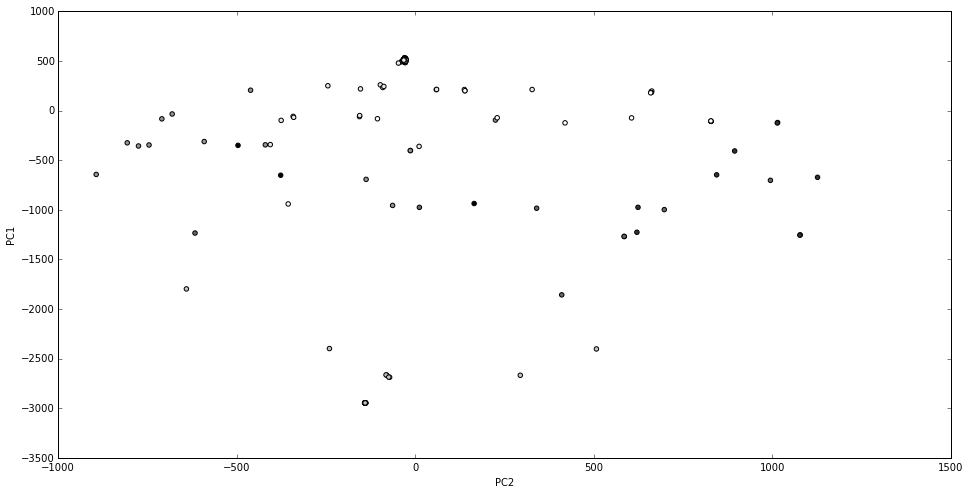

In [20]:
import numpy as np

existing_df_2d.plot(
    kind='scatter',
    x='PC2',y='PC1',
    c=existing_df_2d.cluster.astype(np.float), 
    figsize=(16,8))

The result is pretty much as the one obtained with R, with the color differences and without the country names that we decided not to include here. Next section we will analise each cluster in detail.   